### RAG Multimodal (PDF con Imágenes)

Este notebook demuestra cómo implementar un sistema RAG que procesa tanto texto como imágenes de documentos PDF.

**¿Qué es RAG Multimodal?**
- RAG tradicional solo procesa texto
- RAG Multimodal procesa texto + imágenes + gráficos + tablas
- Usa embeddings unificados (CLIP) para texto e imágenes en el mismo espacio vectorial
- Permite al LLM "ver" imágenes usando GPT-4 Vision

**Flujo del Pipeline:**
```
PDF → Extraer Texto + Imágenes → Embeddings CLIP → Vector Store → Recuperación → GPT-4 Vision → Respuesta
```

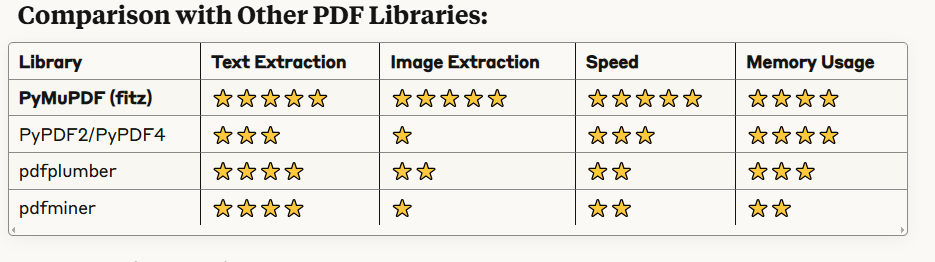

In [1]:
# ========================================
# IMPORTACIONES Y CONFIGURACIÓN INICIAL
# ========================================

# PyMuPDF (fitz): Biblioteca para leer y manipular archivos PDF
import fitz

# Document: Clase de LangChain para representar documentos con contenido y metadatos
from langchain_core.documents import Document

# CLIP: Modelo de OpenAI que genera embeddings unificados para texto e imágenes
# CLIPProcessor: Preprocesa imágenes y texto para el modelo CLIP
# CLIPModel: Modelo neural que mapea imágenes y texto al mismo espacio vectorial
from transformers import CLIPProcessor, CLIPModel

# PIL (Python Imaging Library): Para manipular imágenes
from PIL import Image

# PyTorch: Framework de deep learning necesario para ejecutar CLIP
import torch

# NumPy: Para operaciones numéricas con arrays y vectores
import numpy as np

# init_chat_model: Función de LangChain para inicializar modelos de chat (GPT-4)
from langchain.chat_models import init_chat_model

# PromptTemplate: Para crear plantillas de prompts con variables
from langchain.prompts import PromptTemplate

# HumanMessage: Clase para representar mensajes del usuario (soporta multimodal)
from langchain.schema.messages import HumanMessage

# cosine_similarity: Calcula similitud del coseno entre vectores (para búsqueda)
from sklearn.metrics.pairwise import cosine_similarity

# os: Para interactuar con el sistema operativo (variables de entorno)
import os

# base64: Para codificar imágenes en formato base64 (requerido por GPT-4 Vision)
import base64

# io: Para trabajar con streams de bytes (conversión de imágenes)
import io

# RecursiveCharacterTextSplitter: Divide texto en chunks de manera recursiva
from langchain.text_splitter import RecursiveCharacterTextSplitter

# FAISS: Base de datos vectorial de Facebook para búsqueda de similitud eficiente
from langchain_community.vectorstores import FAISS

c:\Udemy\RAGBootcamp\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# ========================================
# CONFIGURACIÓN DEL MODELO CLIP
# ========================================

# Importar módulos para cargar variables de entorno
import os
from dotenv import load_dotenv

# Cargar las variables de entorno desde el archivo .env
# Este archivo contiene las API keys de forma segura
load_dotenv()

# Establecer la API key de OpenAI desde las variables de entorno
# Esta clave es necesaria para usar GPT-4 Vision posteriormente
os.environ["OPENAI_API_KEY"] = os.getenv("OPENAI_API_KEY")

# Inicializar el modelo CLIP de OpenAI
# CLIP (Contrastive Language-Image Pre-training) es un modelo que:
# - Genera embeddings en el mismo espacio vectorial para texto e imágenes
# - Permite buscar imágenes con texto y viceversa
# - Fue entrenado con 400 millones de pares (imagen, texto)
# "clip-vit-base-patch32" es la versión base del modelo (Vision Transformer)
clip_model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")

# Inicializar el procesador CLIP
# El procesador preprocesa imágenes y texto antes de pasarlos al modelo:
# - Redimensiona y normaliza imágenes
# - Tokeniza texto
clip_processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

# Poner el modelo en modo evaluación (no entrenamiento)
# Esto desactiva dropout y batch normalization para inferencia más rápida y consistente
clip_model.eval()

c:\Udemy\RAGBootcamp\.venv\Lib\site-packages\huggingface_hub\file_download.py:143: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\raule\.cache\huggingface\hub\models--openai--clip-vit-base-patch32. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)
Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP dow

CLIPModel(
  (text_model): CLIPTextTransformer(
    (embeddings): CLIPTextEmbeddings(
      (token_embedding): Embedding(49408, 512)
      (position_embedding): Embedding(77, 512)
    )
    (encoder): CLIPEncoder(
      (layers): ModuleList(
        (0-11): 12 x CLIPEncoderLayer(
          (self_attn): CLIPAttention(
            (k_proj): Linear(in_features=512, out_features=512, bias=True)
            (v_proj): Linear(in_features=512, out_features=512, bias=True)
            (q_proj): Linear(in_features=512, out_features=512, bias=True)
            (out_proj): Linear(in_features=512, out_features=512, bias=True)
          )
          (layer_norm1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
          (mlp): CLIPMLP(
            (activation_fn): QuickGELUActivation()
            (fc1): Linear(in_features=512, out_features=2048, bias=True)
            (fc2): Linear(in_features=2048, out_features=512, bias=True)
          )
          (layer_norm2): LayerNorm((512,), eps=1e-05,

In [4]:
# ========================================
# FUNCIONES DE EMBEDDING MULTIMODAL
# ========================================

def embed_image(image_data):
    """
    Genera un embedding vectorial de una imagen usando el modelo CLIP.
    
    Este embedding es un vector de 512 dimensiones que representa el contenido
    semántico de la imagen en el mismo espacio que los embeddings de texto.
    
    Args:
        image_data: Puede ser una ruta al archivo de imagen (str) o un objeto PIL Image
    
    Returns:
        numpy.ndarray: Vector normalizado de 512 dimensiones
    """
    # Verificar si image_data es una ruta de archivo (string)
    if isinstance(image_data, str):
        # Abrir la imagen desde la ruta y convertir a RGB (3 canales de color)
        # RGB es necesario porque CLIP espera imágenes a color
        image = Image.open(image_data).convert("RGB")
    else:
        # Si ya es un objeto PIL Image, usar directamente
        image = image_data
    
    # Preprocesar la imagen usando el procesador CLIP
    # - Redimensiona a 224x224 píxeles
    # - Normaliza los valores de píxeles
    # - return_tensors="pt" devuelve tensores de PyTorch
    inputs = clip_processor(images=image, return_tensors="pt")
    
    # Desactivar el cálculo de gradientes (no estamos entrenando)
    # Esto ahorra memoria y acelera el procesamiento
    with torch.no_grad():
        # Pasar la imagen por el modelo CLIP para obtener embeddings
        # get_image_features extrae características visuales de la imagen
        features = clip_model.get_image_features(**inputs)
        
        # Normalizar el vector a longitud unitaria (norma L2 = 1)
        # Esto permite usar similitud del coseno de forma eficiente
        # dim=-1 normaliza a lo largo de la última dimensión (el vector de features)
        # keepdim=True mantiene las dimensiones para la división
        features = features / features.norm(dim=-1, keepdim=True)
        
        # squeeze() elimina dimensiones de tamaño 1
        # numpy() convierte el tensor de PyTorch a array de NumPy
        return features.squeeze().numpy()


def embed_text(text):
    """
    Genera un embedding vectorial de texto usando el modelo CLIP.
    
    Este embedding es un vector de 512 dimensiones que representa el contenido
    semántico del texto en el mismo espacio que los embeddings de imágenes.
    
    Args:
        text (str): Texto a convertir en embedding
    
    Returns:
        numpy.ndarray: Vector normalizado de 512 dimensiones
    """
    # Preprocesar el texto usando el procesador CLIP
    inputs = clip_processor(
        text=text,  # Texto de entrada
        return_tensors="pt",  # Devolver tensores de PyTorch
        padding=True,  # Agregar padding para igualar longitudes
        truncation=True,  # Truncar si excede max_length
        max_length=77  # Longitud máxima de tokens que CLIP puede procesar
    )
    
    # Desactivar el cálculo de gradientes
    with torch.no_grad():
        # Extraer características textuales usando CLIP
        # get_text_features procesa el texto tokenizado
        features = clip_model.get_text_features(**inputs)
        
        # Normalizar los embeddings a vector unitario
        # Esto es crucial para que la similitud del coseno funcione correctamente
        features = features / features.norm(dim=-1, keepdim=True)
        
        # Convertir a NumPy array y eliminar dimensiones extras
        return features.squeeze().numpy()

In [5]:
# ========================================
# CONFIGURACIÓN INICIAL PARA PROCESAR PDF
# ========================================

# Ruta al archivo PDF que vamos a procesar
# Este PDF contiene tanto texto como imágenes (gráficos, diagramas, etc.)
pdf_path = "multimodal_sample.pdf"

# Abrir el documento PDF usando PyMuPDF (fitz)
# fitz.open() devuelve un objeto Document que permite iterar por páginas
doc = fitz.open(pdf_path)

# Lista para almacenar todos los documentos procesados (texto e imágenes)
# Cada elemento será un objeto Document de LangChain con contenido y metadatos
all_docs = []

# Lista para almacenar todos los embeddings (vectores)
# Cada embedding corresponde a un documento en all_docs (mismo índice)
all_embeddings = []

# Diccionario para almacenar las imágenes en formato base64
# Clave: image_id (ej: "page_0_img_0")
# Valor: imagen codificada en base64
# Estas imágenes se enviarán a GPT-4 Vision más tarde
image_data_store = {}

# Inicializar el text splitter para dividir texto en chunks
# chunk_size=500: Cada fragmento tendrá máximo 500 caracteres
# chunk_overlap=100: Superposición de 100 caracteres entre fragmentos
# La superposición ayuda a mantener el contexto entre chunks adyacentes
splitter = RecursiveCharacterTextSplitter(chunk_size=500, chunk_overlap=100)

In [6]:
# Mostrar el objeto documento para inspección
# Esto muestra información básica del PDF (nombre, número de páginas, etc.)
doc

Document('multimodal_sample.pdf')

In [7]:
# ========================================
# PROCESAMIENTO DEL PDF: TEXTO E IMÁGENES
# ========================================

# Iterar por cada página del documento PDF
# enumerate() proporciona tanto el índice (i) como el objeto página
for i, page in enumerate(doc):
    
    # =====================================
    # PARTE 1: PROCESAR TEXTO DE LA PÁGINA
    # =====================================
    
    # Extraer todo el texto de la página actual
    # get_text() devuelve el texto plano de la página
    text = page.get_text()
    
    # Verificar si hay texto no vacío en la página
    # strip() elimina espacios en blanco al inicio y final
    if text.strip():
        # Crear un documento temporal para dividir en chunks
        # Document es la clase de LangChain con page_content y metadata
        temp_doc = Document(
            page_content=text,  # Contenido de texto de la página
            metadata={"page": i, "type": "text"}  # Metadatos: número de página y tipo
        )
        
        # Dividir el documento en fragmentos (chunks) más pequeños
        # split_documents() devuelve una lista de Documents más pequeños
        # Esto es importante porque los LLMs tienen límites de contexto
        text_chunks = splitter.split_documents([temp_doc])
        
        # Procesar cada chunk de texto individualmente
        for chunk in text_chunks:
            # Generar embedding del chunk usando CLIP
            # Este embedding permite buscar este texto con consultas textuales o visuales
            embedding = embed_text(chunk.page_content)
            
            # Agregar el embedding a la lista de embeddings
            all_embeddings.append(embedding)
            
            # Agregar el documento chunk a la lista de documentos
            all_docs.append(chunk)
    
    
    # =====================================
    # PARTE 2: PROCESAR IMÁGENES DE LA PÁGINA
    # =====================================
    
    # Tres acciones importantes para cada imagen:
    # 1. Convertir la imagen del PDF a formato PIL (Python Imaging Library)
    # 2. Almacenar como base64 para GPT-4 Vision (que requiere imágenes en base64)
    # 3. Crear embedding CLIP para recuperación semántica
    
    # Iterar por cada imagen encontrada en la página
    # get_images(full=True) devuelve información completa de todas las imágenes
    for img_index, img in enumerate(page.get_images(full=True)):
        try:
            # Obtener el xref (referencia cruzada) de la imagen
            # xref es un identificador único de la imagen en el PDF
            xref = img[0]
            
            # Extraer la imagen del PDF usando su xref
            # extract_image() devuelve un diccionario con datos de la imagen
            base_image = doc.extract_image(xref)
            
            # Obtener los bytes de la imagen (datos binarios)
            image_bytes = base_image["image"]
            
            # Convertir los bytes a objeto PIL Image
            # io.BytesIO() crea un stream de bytes en memoria
            # convert("RGB") asegura que la imagen tenga 3 canales de color
            pil_image = Image.open(io.BytesIO(image_bytes)).convert("RGB")
            
            # Crear un identificador único para esta imagen
            # Formato: "page_{número_página}_img_{índice_imagen}"
            # Ejemplo: "page_0_img_0" para la primera imagen de la primera página
            image_id = f"page_{i}_img_{img_index}"
            
            # Almacenar la imagen como base64 para uso posterior con GPT-4 Vision
            # GPT-4 Vision requiere imágenes en formato base64 en la URL de datos
            
            # Crear un buffer en memoria para guardar la imagen
            buffered = io.BytesIO()
            
            # Guardar la imagen PIL en el buffer en formato PNG
            pil_image.save(buffered, format="PNG")
            
            # Codificar los bytes del buffer en base64
            # b64encode() convierte bytes a base64
            # decode() convierte bytes base64 a string
            img_base64 = base64.b64encode(buffered.getvalue()).decode()
            
            # Guardar la imagen base64 en el diccionario con su ID
            image_data_store[image_id] = img_base64
            
            # Generar embedding de la imagen usando CLIP
            # Este embedding permite buscar la imagen con consultas textuales
            # Por ejemplo: "gráfico de barras" puede encontrar esta imagen
            embedding = embed_image(pil_image)
            
            # Agregar el embedding de la imagen a la lista
            all_embeddings.append(embedding)
            
            # Crear un documento para representar la imagen
            # page_content contiene un marcador de posición con el ID
            # metadata almacena información sobre la imagen
            image_doc = Document(
                page_content=f"[Imagen: {image_id}]",  # Marcador de posición
                metadata={
                    "page": i,  # Número de página
                    "type": "image",  # Tipo de contenido
                    "image_id": image_id  # ID único de la imagen
                }
            )
            
            # Agregar el documento de imagen a la lista
            all_docs.append(image_doc)
            
        except Exception as e:
            # Si hay algún error procesando la imagen, imprimir mensaje y continuar
            # Esto evita que una imagen corrupta detenga todo el procesamiento
            print(f"Error procesando imagen {img_index} en página {i}: {e}")
            continue

# Cerrar el documento PDF para liberar recursos
doc.close()

In [8]:
# Mostrar todos los documentos procesados (texto e imágenes)
# Esto permite inspeccionar qué se extrajo del PDF
all_docs

[Document(metadata={'page': 0, 'type': 'text'}, page_content='Annual Revenue Overview\nThis document summarizes the revenue trends across Q1, Q2, and Q3. As illustrated in the chart\nbelow, revenue grew steadily with the highest growth recorded in Q3.\nQ1 showed a moderate increase in revenue as new product lines were introduced. Q2 outperformed\nQ1 due to marketing campaigns. Q3 had exponential growth due to global expansion.'),
 Document(metadata={'page': 0, 'type': 'image', 'image_id': 'page_0_img_0'}, page_content='[Imagen: page_0_img_0]')]

In [9]:
# ========================================
# PREPARAR EMBEDDINGS PARA VECTOR STORE
# ========================================

# Convertir la lista de embeddings a un array de NumPy
# NumPy es más eficiente para operaciones vectoriales
# El array resultante tiene forma (n_documentos, 512)
# donde 512 es la dimensión de los embeddings CLIP
embeddings_array = np.array(all_embeddings)

# Mostrar el array de embeddings para inspección
# Podemos ver las dimensiones y algunos valores
embeddings_array

array([[-0.00267245,  0.01283001, -0.05183142, ..., -0.00385085,
         0.02977719, -0.00010682],
       [ 0.01732343, -0.01327688, -0.02427032, ...,  0.08994049,
        -0.00272151,  0.0325304 ]], shape=(2, 512), dtype=float32)

In [10]:
# Mostrar la tupla de documentos y embeddings juntos
# Esto permite verificar que cada documento tiene su embedding correspondiente
(all_docs, embeddings_array)

([Document(metadata={'page': 0, 'type': 'text'}, page_content='Annual Revenue Overview\nThis document summarizes the revenue trends across Q1, Q2, and Q3. As illustrated in the chart\nbelow, revenue grew steadily with the highest growth recorded in Q3.\nQ1 showed a moderate increase in revenue as new product lines were introduced. Q2 outperformed\nQ1 due to marketing campaigns. Q3 had exponential growth due to global expansion.'),
  Document(metadata={'page': 0, 'type': 'image', 'image_id': 'page_0_img_0'}, page_content='[Imagen: page_0_img_0]')],
 array([[-0.00267245,  0.01283001, -0.05183142, ..., -0.00385085,
          0.02977719, -0.00010682],
        [ 0.01732343, -0.01327688, -0.02427032, ...,  0.08994049,
         -0.00272151,  0.0325304 ]], shape=(2, 512), dtype=float32))

In [11]:
# ========================================
# CREAR BASE DE DATOS VECTORIAL FAISS
# ========================================

# Crear un vector store FAISS usando embeddings precalculados
# FAISS (Facebook AI Similarity Search) es una biblioteca optimizada
# para búsqueda de similitud de vectores de alta dimensión

# from_embeddings() crea el índice desde embeddings ya calculados
vector_store = FAISS.from_embeddings(
    # text_embeddings: lista de tuplas (texto, embedding)
    # zip() combina docs y embeddings en tuplas paralelas
    # El texto se usa como identificador en el índice
    text_embeddings=[
        (doc.page_content, emb) 
        for doc, emb in zip(all_docs, embeddings_array)
    ],
    
    # embedding=None porque ya tenemos los embeddings calculados
    # Si pasáramos un objeto Embeddings, FAISS recalcularía los embeddings
    embedding=None,
    
    # metadatas: lista de diccionarios con metadatos de cada documento
    # Estos metadatos se pueden usar para filtrar búsquedas
    metadatas=[doc.metadata for doc in all_docs]
)

# Mostrar el objeto vector_store para confirmación
vector_store

`embedding_function` is expected to be an Embeddings object, support for passing in a function will soon be removed.


In [12]:
# ========================================
# INICIALIZAR GPT-4 VISION
# ========================================

# Inicializar el modelo GPT-4 con capacidades de visión
# GPT-4 Vision puede procesar tanto texto como imágenes
# "gpt-4.1" es una versión optimizada de GPT-4 con soporte multimodal
llm = init_chat_model("openai:gpt-4.1")

# Mostrar la configuración del LLM
llm

ChatOpenAI(client=<openai.resources.chat.completions.completions.Completions object at 0x0000022124F14650>, async_client=<openai.resources.chat.completions.completions.AsyncCompletions object at 0x000002212692BE00>, root_client=<openai.OpenAI object at 0x000002217DFAF3E0>, root_async_client=<openai.AsyncOpenAI object at 0x00000221252AEFC0>, model_name='gpt-4.1', model_kwargs={}, openai_api_key=SecretStr('**********'), stream_usage=True)

In [13]:
# ========================================
# FUNCIÓN DE RECUPERACIÓN MULTIMODAL
# ========================================

def retrieve_multimodal(query, k=5):
    """
    Recupera documentos relevantes (texto e imágenes) usando embeddings CLIP.
    
    Esta función realiza búsqueda semántica unificada donde:
    - Una consulta de texto puede encontrar texto relacionado
    - Una consulta de texto puede encontrar imágenes relacionadas
    - Por ejemplo: "gráfico de ventas" puede encontrar tanto párrafos sobre ventas
      como imágenes de gráficos
    
    Args:
        query (str): Consulta del usuario en texto natural
        k (int): Número de documentos a recuperar (default: 5)
    
    Returns:
        list: Lista de objetos Document más similares a la consulta
    """
    # Convertir la consulta de texto a embedding usando CLIP
    # Este embedding estará en el mismo espacio vectorial que texto e imágenes
    query_embedding = embed_text(query)
    
    # Buscar en el vector store los k documentos más similares
    # similarity_search_by_vector() usa similitud del coseno para encontrar
    # los vectores más cercanos al query_embedding
    # Puede devolver tanto documentos de texto como de imagen
    results = vector_store.similarity_search_by_vector(
        embedding=query_embedding,  # Vector de la consulta
        k=k  # Número de resultados a retornar
    )
    
    # Devolver la lista de documentos recuperados
    return results

In [14]:
# ========================================
# FUNCIÓN PARA CREAR MENSAJE MULTIMODAL
# ========================================

def create_multimodal_message(query, retrieved_docs):
    """
    Crea un mensaje multimodal con texto e imágenes para GPT-4 Vision.
    
    GPT-4 Vision puede procesar mensajes que contienen:
    - Bloques de texto
    - Imágenes codificadas en base64
    - Instrucciones mezcladas
    
    Esta función construye el mensaje en el formato correcto para la API.
    
    Args:
        query (str): Pregunta del usuario
        retrieved_docs (list): Documentos recuperados (texto e imágenes)
    
    Returns:
        HumanMessage: Mensaje formateado con contenido multimodal
    """
    # Lista para almacenar los bloques de contenido del mensaje
    # Cada bloque es un diccionario con "type" y contenido
    content = []
    
    # =====================================
    # PARTE 1: AGREGAR LA CONSULTA
    # =====================================
    
    # Agregar un bloque de texto con la pregunta del usuario
    content.append({
        "type": "text",  # Tipo de contenido: texto
        "text": f"Pregunta: {query}\n\nContexto:\n"  # La pregunta y encabezado
    })
    
    # =====================================
    # PARTE 2: SEPARAR DOCS DE TEXTO E IMAGEN
    # =====================================
    
    # Filtrar documentos de texto usando list comprehension
    # Solo incluye docs donde metadata["type"] == "text"
    text_docs = [doc for doc in retrieved_docs if doc.metadata.get("type") == "text"]
    
    # Filtrar documentos de imagen
    # Solo incluye docs donde metadata["type"] == "image"
    image_docs = [doc for doc in retrieved_docs if doc.metadata.get("type") == "image"]
    
    # =====================================
    # PARTE 3: AGREGAR CONTEXTO DE TEXTO
    # =====================================
    
    # Si hay documentos de texto recuperados
    if text_docs:
        # Combinar todos los fragmentos de texto en un solo string
        # Cada fragmento se formatea como "[Página X]: contenido"
        # join() une los fragmentos con doble salto de línea
        text_context = "\n\n".join([
            f"[Página {doc.metadata['page']}]: {doc.page_content}"
            for doc in text_docs
        ])
        
        # Agregar el contexto textual al mensaje
        content.append({
            "type": "text",
            "text": f"Extractos de texto:\n{text_context}\n"
        })
    
    # =====================================
    # PARTE 4: AGREGAR IMÁGENES
    # =====================================
    
    # Iterar por cada documento de imagen recuperado
    for doc in image_docs:
        # Obtener el ID único de la imagen desde los metadatos
        image_id = doc.metadata.get("image_id")
        
        # Verificar que el ID existe y que tenemos la imagen guardada
        if image_id and image_id in image_data_store:
            # Agregar un texto descriptivo antes de la imagen
            content.append({
                "type": "text",
                "text": f"\n[Imagen de la página {doc.metadata['page']}]:\n"
            })
            
            # Agregar la imagen en formato de URL de datos base64
            # GPT-4 Vision requiere este formato específico:
            # "data:image/png;base64,{datos_base64}"
            content.append({
                "type": "image_url",  # Tipo especial para imágenes
                "image_url": {
                    # URL de datos con la imagen codificada en base64
                    "url": f"data:image/png;base64,{image_data_store[image_id]}"
                }
            })
    
    # =====================================
    # PARTE 5: AGREGAR INSTRUCCIÓN FINAL
    # =====================================
    
    # Agregar instrucciones al LLM sobre cómo responder
    content.append({
        "type": "text",
        "text": "\n\nPor favor, responde la pregunta basándote en el texto e imágenes proporcionadas."
    })
    
    # Crear y devolver un HumanMessage con el contenido multimodal
    # HumanMessage es la clase de LangChain para mensajes del usuario
    return HumanMessage(content=content)

In [15]:
# ========================================
# PIPELINE PRINCIPAL DE RAG MULTIMODAL
# ========================================

def multimodal_pdf_rag_pipeline(query):
    """
    Pipeline principal para RAG Multimodal que procesa PDFs con texto e imágenes.
    
    Flujo completo:
    1. Recuperar documentos relevantes (texto e imágenes) usando CLIP
    2. Crear mensaje multimodal con contexto recuperado
    3. Enviar mensaje a GPT-4 Vision
    4. Obtener y devolver respuesta
    
    Args:
        query (str): Pregunta del usuario en lenguaje natural
    
    Returns:
        str: Respuesta generada por GPT-4 Vision basada en el contexto
    """
    # Paso 1: Recuperar documentos relevantes usando búsqueda vectorial
    # retrieve_multimodal() usa embeddings CLIP para encontrar contenido similar
    # k=5 significa que recuperamos los 5 documentos más relevantes
    context_docs = retrieve_multimodal(query, k=5)
    
    # Paso 2: Crear mensaje multimodal formateado para GPT-4 Vision
    # Combina la consulta, texto recuperado e imágenes en un solo mensaje
    message = create_multimodal_message(query, context_docs)
    
    # Paso 3: Invocar GPT-4 Vision con el mensaje multimodal
    # GPT-4 Vision procesará tanto el texto como las imágenes
    # y generará una respuesta basada en todo el contexto
    response = llm.invoke([message])
    
    # =====================================
    # INFORMACIÓN DE DEBUG
    # =====================================
    
    # Imprimir información sobre los documentos recuperados (para debug)
    print(f"\nRecuperados {len(context_docs)} documentos:")
    
    # Iterar por cada documento recuperado y mostrar su información
    for doc in context_docs:
        # Obtener el tipo de documento (texto o imagen)
        doc_type = doc.metadata.get("type", "desconocido")
        
        # Obtener el número de página
        page = doc.metadata.get("page", "?")
        
        # Si es un documento de texto
        if doc_type == "text":
            # Mostrar preview del contenido (primeros 100 caracteres)
            # Si el contenido es mayor a 100 caracteres, agregar "..."
            preview = doc.page_content[:100] + "..." if len(doc.page_content) > 100 else doc.page_content
            print(f"  - Texto de página {page}: {preview}")
        else:
            # Si es una imagen, solo mostrar que es una imagen
            print(f"  - Imagen de página {page}")
    
    # Imprimir línea separadora para mejor legibilidad
    print("\n")
    
    # Paso 4: Devolver el contenido de la respuesta (solo el texto)
    # response.content contiene el texto generado por GPT-4 Vision
    return response.content

In [16]:
# ========================================
# PRUEBAS DEL PIPELINE CON CONSULTAS DE EJEMPLO
# ========================================

# Verificar si este script se está ejecutando directamente
# (no como módulo importado)
if __name__ == "__main__":
    
    # Lista de consultas de ejemplo para probar el sistema
    # Estas consultas demuestran diferentes capacidades:
    queries = [
        # Consulta 1: Pregunta específica sobre contenido visual
        # Requiere que el LLM "vea" e interprete el gráfico
        "¿Qué muestra el gráfico en la página 1 sobre las tendencias de ingresos?",
        
        # Consulta 2: Pregunta general que requiere sintetizar información
        # Puede usar tanto texto como imágenes para responder
        "Resume los principales hallazgos del documento",
        
        # Consulta 3: Pregunta sobre elementos visuales
        # Prueba la capacidad de identificar y describir contenido visual
        "¿Qué elementos visuales están presentes en el documento?"
    ]
    
    # Iterar por cada consulta de ejemplo
    for query in queries:
        # Imprimir la consulta con formato
        print(f"\nConsulta: {query}")
        print("-" * 50)  # Línea separadora
        
        # Ejecutar el pipeline RAG multimodal completo
        # Esto recupera contexto relevante y genera una respuesta
        answer = multimodal_pdf_rag_pipeline(query)
        
        # Imprimir la respuesta generada por GPT-4 Vision
        print(f"Respuesta: {answer}")
        
        # Línea separadora entre consultas para mejor legibilidad
        print("=" * 70)


Consulta: ¿Qué muestra el gráfico en la página 1 sobre las tendencias de ingresos?
--------------------------------------------------

Recuperados 2 documentos:
  - Texto de página 0: Annual Revenue Overview
This document summarizes the revenue trends across Q1, Q2, and Q3. As illust...
  - Imagen de página 0


Respuesta: El gráfico en la página 1 muestra las tendencias de ingresos a lo largo de tres trimestres (Q1, Q2 y Q3):

- Los ingresos aumentan de manera constante en cada trimestre.
- Q1 tiene el ingreso más bajo (barra azul), seguido de un aumento en Q2 (barra verde), y un crecimiento aún mayor y más pronunciado en Q3 (barra roja).
- Según el texto, el mayor crecimiento se registra en Q3, debido a la expansión global.
- Q1 muestra un aumento moderado por la introducción de nuevas líneas de productos, Q2 mejora gracias a campañas de marketing y Q3 crece exponencialmente.

En resumen, el gráfico muestra una tendencia de crecimiento de ingresos, siendo Q3 el trimestre con el mayor